<a href="https://colab.research.google.com/github/gajanm/DiaDetect/blob/main/DiaDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/research/"

In [3]:
%cd /content/drive/MyDrive/research/

/content/drive/MyDrive/research


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import csv
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
import keras,os
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil
import time
from tensorflow.keras.optimizers import Adam, Adamax, SGD
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras import regularizers

import os


In [8]:
total = pd.read_csv("APTOS.csv")

In [10]:
train_df, temp_df = train_test_split(total, test_size=0.2, random_state=1)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=1)

In [18]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.5, patience=8): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        self.no_improvement_count=0
        self.patience=patience

    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to'
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started

    def on_train_end(self, logs=None):   # runs at the end of training
        msg=f'loading model with weights from epoch {self.best_epoch}'
        self.model.save('EfficientNetB0Model.h5')
        print_in_color(msg, (0,255,255))
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')

        if epoch >0:
            deltav = self.lowest_vloss- vloss
            pimprov=(deltav/self.lowest_vloss) * 100
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.no_improvement_count = 0  # Reset the counter since there is an improvement



            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255,255,0)) # yellow foreground

            self.no_improvement_count += 1  # Increment the counter since there is no improvement

            if self.no_improvement_count >= self.patience:
                msg = f'\nValidation loss has not improved for {self.patience} consecutive epochs. Stopping training.'
                print_in_color(msg, (255, 0, 0))  # Red foreground
                self.model.save('EfficientNetB0Model.h5')
                self.model.stop_training = True  # Halt training


            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights

        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss


In [19]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



In [12]:
height=224
width=224
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=750
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    #img=img/127.5-1
    return img

test batch size:  75   test steps:  10


In [13]:
trgen=ImageDataGenerator(preprocessing_function=scalar,
                         horizontal_flip=True,
                         rotation_range=30,
                         brightness_range = [0.8, 1.2]
                         )
tvgen=ImageDataGenerator(preprocessing_function=scalar)

In [15]:
X = train_df['filepaths']
y = train_df['labels']

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import csv
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler, Callback
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns


In [32]:
epochs = 80
patience= 1
stop_patience = 8
threshold=.9
factor=.5
dwell=True
freeze=False
ask_epoch=40

In [48]:
train_gen = trgen.flow_from_dataframe(
      train_df,
      x_col='filepaths',
      y_col='labels',
      target_size=img_size,
      class_mode='categorical',
      color_mode='rgb',
      shuffle=True,
      batch_size=batch_size
)

train_steps=int(len(train_gen.labels)/batch_size)
batches=train_steps

valid_gen = tvgen.flow_from_dataframe(
    val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

    # ... (your existing code, create model, compile, and define callbacks)
model_name='EfficientNetB0'
base_model=tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                        bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(5, activation='softmax')(x)
efficientnetb0=Model(inputs=base_model.input, outputs=output)
efficientnetb0.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

callbacks=[LR_ASK(model=efficientnetb0,
                       epochs=epochs,  ask_epoch=40)]

    # Fit the model for the current fold and store the history
history = efficientnetb0.fit(x=train_gen,   epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
            validation_steps=None,  shuffle=False,  initial_epoch=0)


Found 6000 validated image filenames belonging to 5 classes.
Found 750 validated image filenames belonging to 5 classes.
ask_epoch >= epochs, will train for  40  epochs
Training will proceed until epoch 40 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/40
150/150 [==============================] - ETA: 0s - loss: 7.1826 - accuracy: 0.5255 - auc: 0.8205 - precision: 0.6525 - recall: 0.3395
 validation loss of  5.8826 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

150/150 [==============================] - 160s 850ms/step - loss: 7.1826 - accuracy: 0.5255 - auc: 0.8205 - precision: 0.6525 - recall: 0.3395 - val_loss: 5.8826 - val_accuracy: 0.5933 - val_auc: 0.8684 - val_precision: 0.7170 - val_recall: 0.4560
Epoch 2/40
150/150 [==============================] - ETA: 0s - loss: 4.8041 - accuracy: 0.6315 - auc: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


learning rate was automatically adjusted from 0.000001 to 0.000000, model weights set to best weights

150/150 [==============================] - 129s 858ms/step - loss: 0.2453 - accuracy: 0.9792 - auc: 0.9993 - precision: 0.9850 - recall: 0.9727 - val_loss: 0.5265 - val_accuracy: 0.8747 - val_auc: 0.9768 - val_precision: 0.8874 - val_recall: 0.8613
loading model with weights from epoch 24

training elapsed time was 1.0 hours,  9.0 minutes, 31.46 seconds)



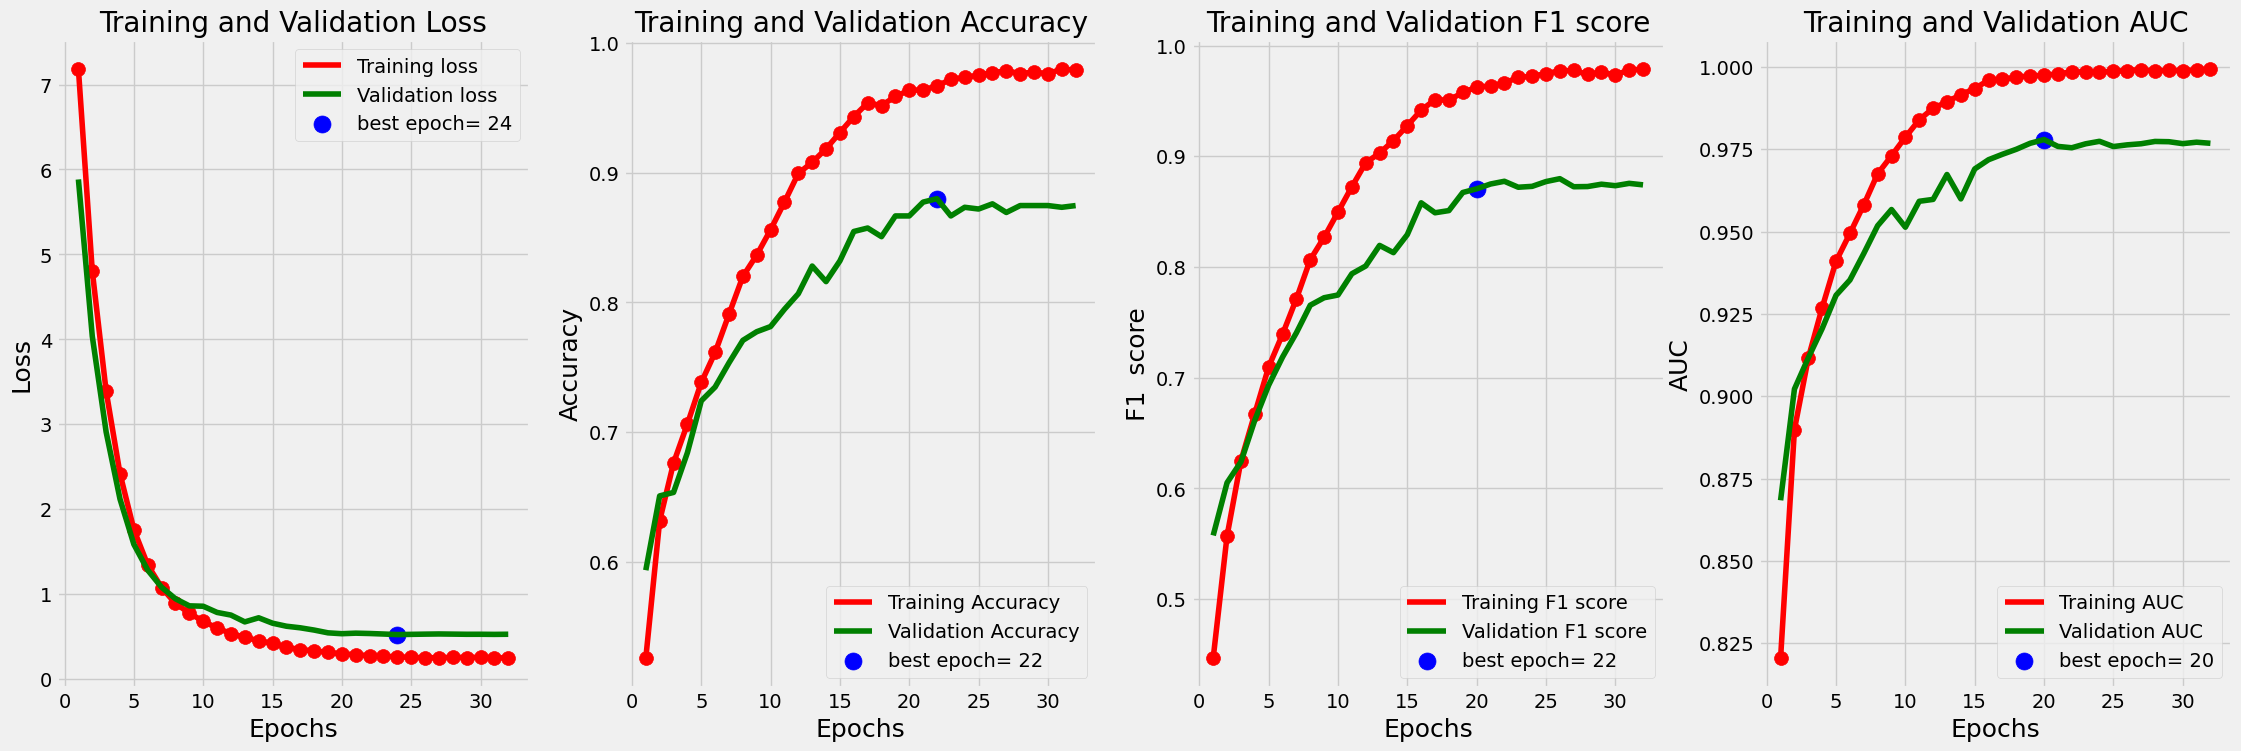

In [49]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tprec= tr_data.history['precision']
    vprec=tr_data.history['val_precision']
    trecall= tr_data.history['recall']
    vrecall= tr_data.history['val_recall']
    #tf1=tr_data.history['F1_score']
    #vf1=tr_data.history['val_F1_score']
    tauc=tr_data.history['auc']
    vauc=tr_data.history['val_auc']
    tf1 = [(2 * p * r) / (p + r) if (p + r) != 0 else 0 for p, r in zip(tprec, trecall)]
    vf1 = [(2 * p * r) / (p + r) if (p + r) != 0 else 0 for p, r in zip(vprec, vrecall)]

    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    auc_index=np.argmax(vauc)
    val_highest_auc=vauc[auc_index]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    auc_label='best epoch= ' + str(auc_index + 1 + start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=4, figsize=(25,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=19#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]

    index_vf1=19# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()

    axes[3].plot(Epochs,tauc, 'r', label='Training AUC')
    axes[3].plot(Epochs,vauc,'g',label='Validation AUC' )
    axes[3].scatter(auc_index+1 +start_epoch,val_highest_auc, s=150, c= 'blue', label=auc_label)
    axes[3].scatter(Epochs, tauc, s=100, c='red')
    axes[3].set_title('Training and Validation AUC')
    axes[3].set_xlabel('Epochs', fontsize=18)
    axes[3].set_ylabel('AUC', fontsize=18)
    axes[3].legend()
    plt.tight_layout
    plt.show()
    return

tr_plot(history)

In [50]:
tsgen = ImageDataGenerator(preprocessing_function=scalar)

test_gen = tsgen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 750 validated image filenames belonging to 5 classes.


In [37]:
test = efficientnetb0.predict(test_gen)




19/19 [==============================] - 310s 17s/step


In [38]:
true_labels = test_gen.classes  # Get labels from the generator
n_classes = len(np.unique(true_labels))

In [39]:
from keras.utils import to_categorical
true_labels = to_categorical(true_labels, num_classes=n_classes)

In [40]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [41]:
for i in range(n_classes):
   print(f'ROC AUC for class {i}: {roc_auc[i]}')

ROC AUC for class 0: 0.9851254332398085
ROC AUC for class 1: 0.9513153757467769
ROC AUC for class 2: 0.9989702853780524
ROC AUC for class 3: 0.9774292433022591
ROC AUC for class 4: 0.989519704295972


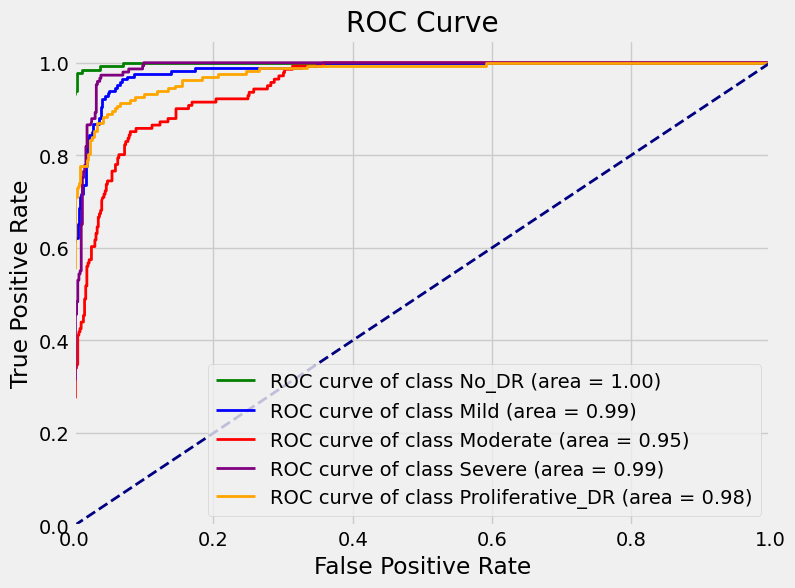

In [42]:
class_labels = ['Mild', 'Moderate', 'No_DR', 'Proliferative_DR', 'Severe']
colors = ['blue', 'red', 'green', 'orange', 'purple']

plt.figure(figsize=(8, 6))

# Define the custom plotting order
plot_order = [2, 0, 1, 4, 3]

for i in plot_order:
    label = class_labels[i]
    color = colors[i]
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(label, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [43]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    print(new_dict)
    classes=list(new_dict.values())
    print(classes)     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')

    y_true= np.array(labels)

    y_pred=np.array(y_pred)









    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        new_orders = [2, 0, 1, 4, 3]
        print(new_orders)
        reordered_cm = cm[new_orders][:, new_orders]

        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(reordered_cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        #plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        #plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xticks(np.arange(length) + 0.5, [classes[i] for i in new_orders], rotation=90)
        plt.yticks(np.arange(length) + 0.5, [classes[i] for i in new_orders], rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

    cm = confusion_matrix(y_true, y_pred)

    total = np.sum(cm, axis=1)
    true_positives = np.diag(cm)
    false_positives = np.sum(cm, axis=0) - true_positives
    false_negatives = total - true_positives

    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_positives / (true_positives + false_positives)

    sensitivity_dict = {classes[i]: sensitivity[i] for i in range(len(classes))}
    specificity_dict = {classes[i]: specificity[i] for i in range(len(classes))}

    print(sensitivity_dict, specificity_dict)







In [ ]:
print_code = 0
save_dir = "./"
subject='classes'

print_info( test_gen, test, print_code, save_dir, subject )

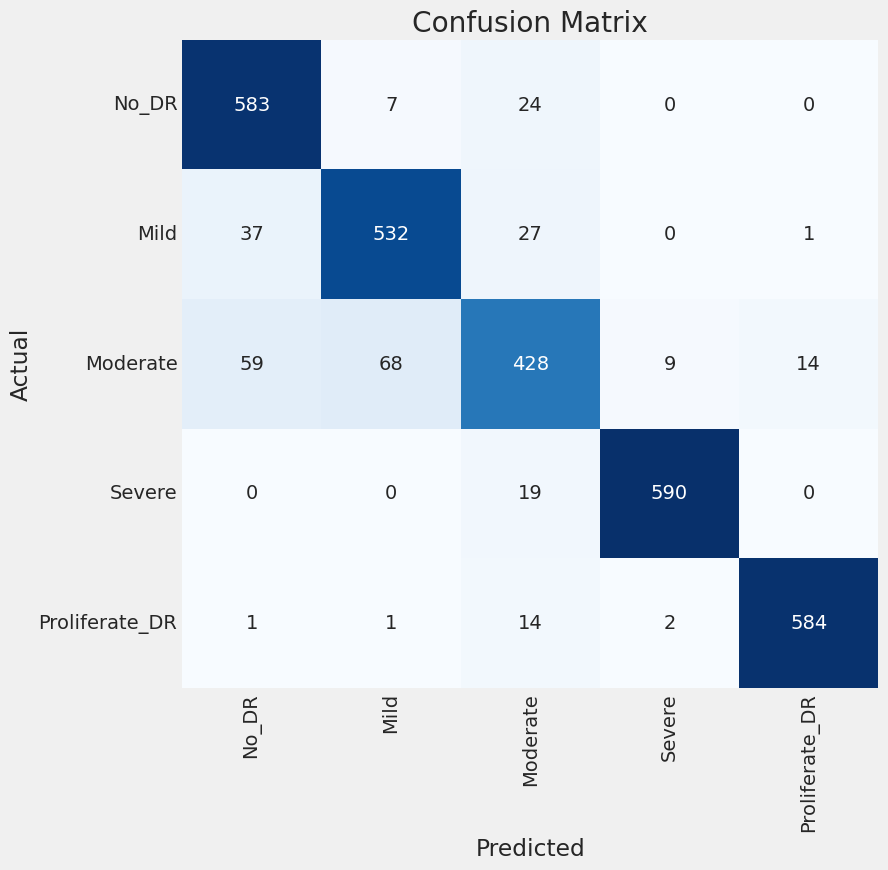

Classification Report:
----------------------
                 precision    recall  f1-score   support

          Mild       0.88      0.89      0.88       597
      Moderate       0.84      0.74      0.79       578
         No_DR       0.86      0.95      0.90       614
Proliferate_DR       0.97      0.97      0.97       602
        Severe       0.98      0.97      0.98       609

      accuracy                           0.91      3000
     macro avg       0.90      0.90      0.90      3000
  weighted avg       0.91      0.91      0.90      3000